In [66]:
import pandas as pd
import numpy as np
import missingno as msn

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv('train.csv')
train.sample(3)

,price,type,time,link,address,title,area,bedroom_num,house_type,toilet_num,direction,legcal_doc,block_name,total_floor,housing_feature,city,district,ward,street,description
11179,2.200000e+09,Môi giới,11/4/2019 18:08,https://nha.chotot.com//tp-ho-chi-minh/huyen-b...,"11/15, Đường Đinh Đức Thiện, Xã Bình Chánh, Hu...","Nhà cấp 4 có lửng 118m2 hẻm xe hơi, chợ bình c...",118.0,2.0,Nhà,1.0,NaN,Đang chờ bàn giao sổ,NaN,1,Nở hậu,Tp Hồ Chí Minh,Huyện Bình Chánh,Xã Bình Chánh,Đường Đinh Đức Thiện,Dự án: Nhà dân ở.\nThông tin chi tiết: Nhà sát...
9501,8.300000e+09,Huỳnh Khánh,11/21/2019 13:34,https://nha.chotot.com//tp-ho-chi-minh/quan-7/...,"Đường Lâm Văn Bền, Phường Tân Kiểng, Quận 7, T...",Góc bán nhà !!! Cần bán gấp căn nhà địa chỉ 62...,60.0,4.0,Nhà,4.0,NaN,Đã có sổ đỏ/sổ hồng,NaN,4,Hẻm xe hơi,Tp Hồ Chí Minh,Quận 7,Phường Tân Kiểng,Đường Lâm Văn Bền,Cần bán gấp căn nhà địa chỉ 62 Lâm Văn Bền Phư...
3211,6.900000e+09,Anh Huấn,11/21/2019 10:40,https://nha.chotot.com//tp-ho-chi-minh/quan-ph...,"120/86/14, Đường Thích Quảng Đức, Phường 5, Qu...",Nhà 42m² Thích Quảng Đức Phú Nhuận,42.0,6.0,Nhà,4.0,NaN,Đã có sổ đỏ/sổ hồng,NaN,3,Hẻm xe hơi,Tp Hồ Chí Minh,Quận Phú Nhuận,Phường 5,Đường Thích Quảng Đức,"chính chủ bán căn 120/86/14 Thích Quảng Đức,ph..."


In [3]:
x = train.price.describe()

In [4]:
class CatePriceDrop(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        details = X_df.price.describe()
        self._25 = details['25%']
        self._50 = details['50%']
        self._75 = details['75%']
        return self
    
    def to_cate(self, x):
        if x < self._25:
            return 1
        if x < self._50:
            return 2
        if x < self._75:
            return 3
        return 4
    
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        res_df['label'] = res_df['price'].apply(lambda x: self.to_cate(x))
        res_df['type'] = res_df['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
        res_df.drop(columns=['price','time','link','address',
                             'title','city','description',
                             'block_name','total_floor','direction'], inplace=True)
        return res_df

In [5]:
cate = CatePriceDrop()
train_transform = cate.fit_transform(train)
train_transform.sample(5)

,type,area,bedroom_num,house_type,toilet_num,legcal_doc,housing_feature,district,ward,street,label
6610,Môi giới,20.0,2.0,Nhà,1.0,Đã có sổ đỏ/sổ hồng,Nở hậu,Quận 1,Phường Tân Định,NaN,4
10128,Môi giới,80.0,2.0,Nhà,1.0,Đã có sổ đỏ/sổ hồng,NaN,Huyện Hóc Môn,Xã Tân Thới Nhì,Đường Dương Công Khi,1
10384,Khác,100.0,3.0,Nhà,NaN,NaN,NaN,Huyện Bình Chánh,Xã An Phú Tây,Đường Đinh Đức Thiện,1
1965,Môi giới,72.0,2.0,Nhà,3.0,Đã có sổ đỏ/sổ hồng,Nở hậu,Quận 8,Phường 15,Đường Lê Thành Phương,2
8534,Môi giới,40.0,2.0,Nhà,2.0,Đã có sổ đỏ/sổ hồng,NaN,Huyện Nhà Bè,Xã Phước Kiển,Đường Lê Văn Lương,2


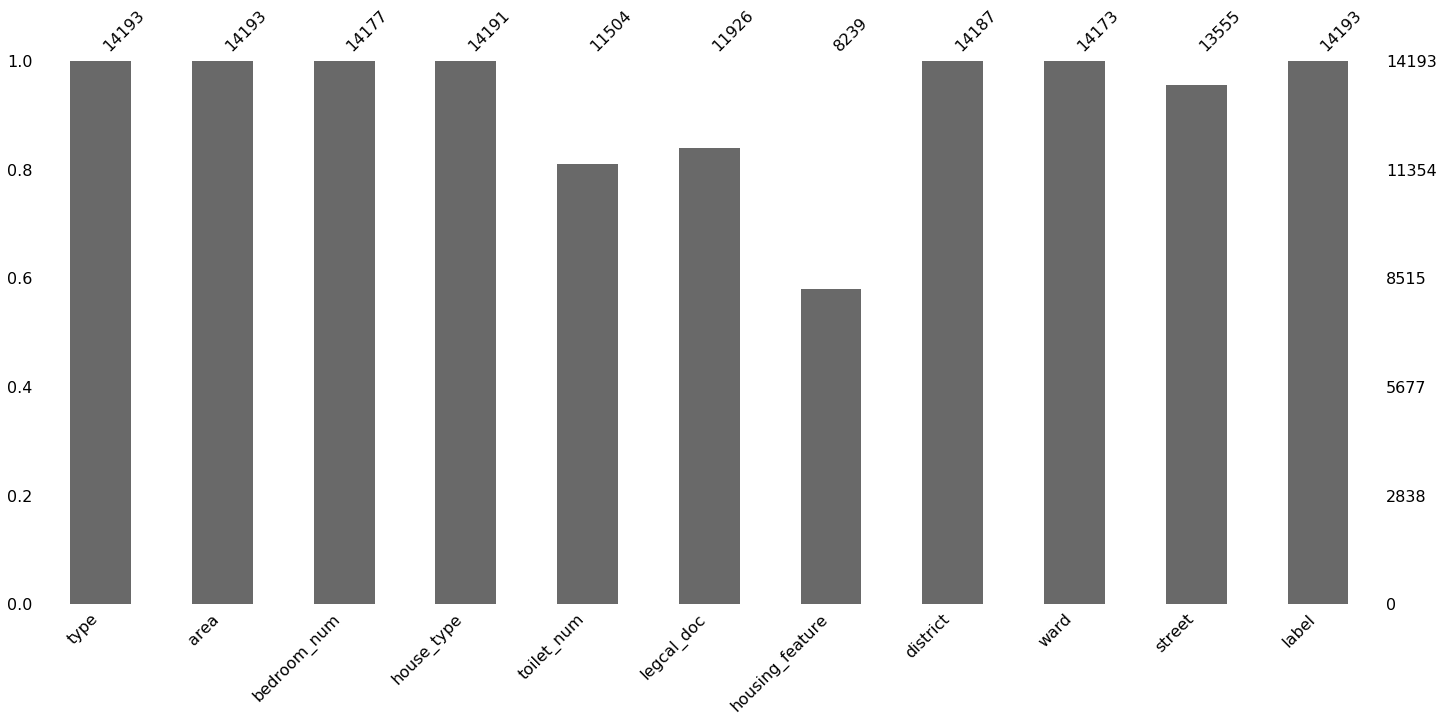

In [6]:
msn.bar(train_transform)

In [7]:
train_transform.toilet_num.describe()

count    11504.000000
mean         2.873001
std          1.555417
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          7.000000
Name: toilet_num, dtype: float64

In [8]:
train_transform.legcal_doc.describe()

count                   11926
unique                      3
top       Đã có sổ đỏ/sổ hồng
freq                    11392
Name: legcal_doc, dtype: object

In [9]:
train_transform.legcal_doc.unique()

array(['Đã có sổ đỏ/sổ hồng', nan, 'Giấy tay', 'Đang chờ bàn giao sổ'],
      dtype=object)

In [10]:
train_transform.housing_feature.describe()

count           8239
unique             3
top       Hẻm xe hơi
freq            3556
Name: housing_feature, dtype: object

In [11]:
train_transform.housing_feature.unique()

array(['Hẻm xe hơi', nan, 'Nở hậu', 'Mặt tiền'], dtype=object)

- Fill `toilet_num` nan with `0.0`
- Fill `legcal_doc` nan with `Không có`
- Fill `housing_feature` nan with `Khác`
- Fill `bedroom_num` nan with `0.0`
- Fill `house_type` nan with `Khác`
- Fill `district`, `ward` and `street` nan with most_frequence

In [12]:
class FillNA(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        mode_street = X_df.street.describe()['top']
        mode_district = X_df.district.describe()['top']
        mode_ward = X_df.ward.describe()['top']
        self.mode_cols = {'street': mode_street, 
                          'district': mode_district, 
                          'ward': mode_ward}
        return self
    
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        other_cols = ['housing_feature', 'house_type']
        _0_cols = ['bedroom_num', 'toilet_num']
        for i in self.mode_cols:
            j = self.mode_cols[i]
            res_df[i].fillna(j, inplace=True)
        for i in other_cols:
            res_df[i].fillna('Khác',inplace=True)
        for i in _0_cols:
            res_df[i].fillna(0.0,inplace=True)
        res_df['legcal_doc'].fillna('Không có', inplace=True)
        return res_df

In [13]:
fillna = FillNA()
train_pre = fillna.fit_transform(train_transform)

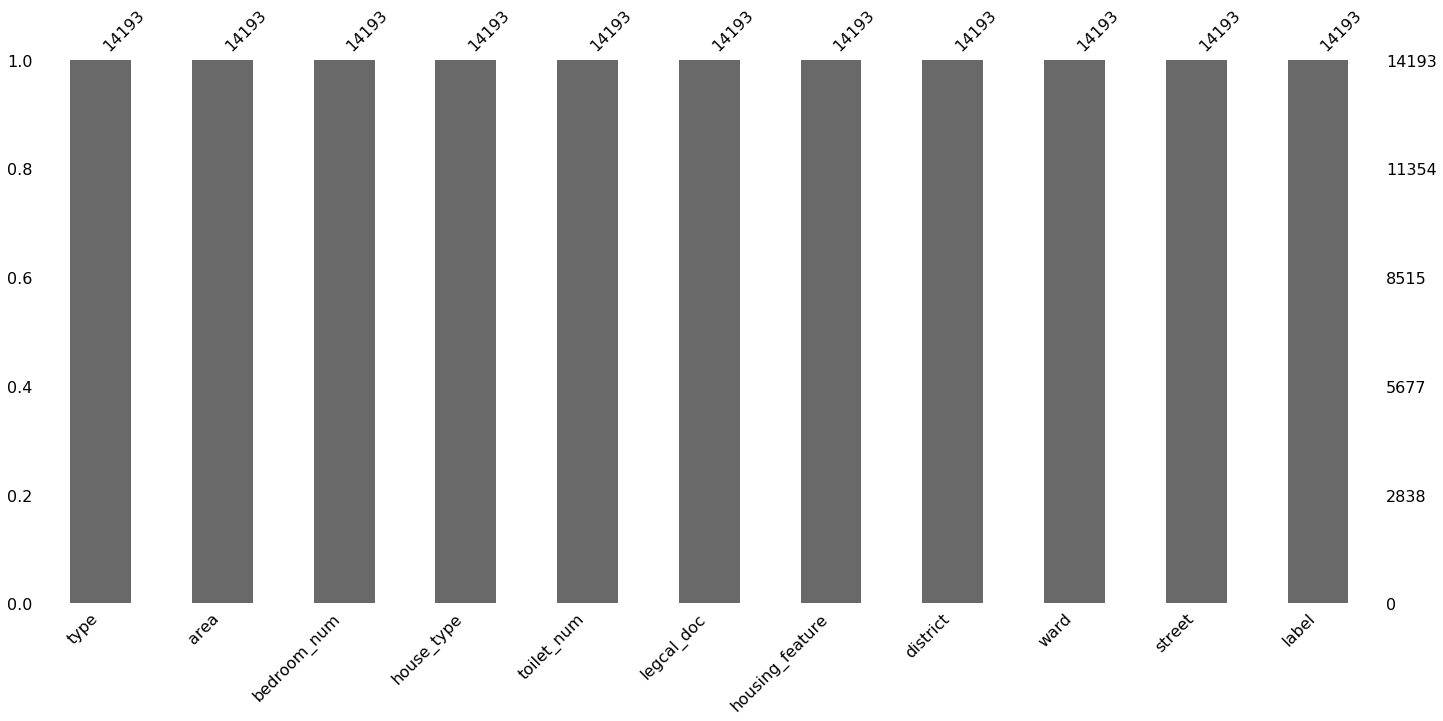

In [14]:
msn.bar(train_pre)

In [43]:
cate_cols = ['type', 'house_type', 'legcal_doc', 'housing_feature', 'district', 'ward', 'street']

scaler = StandardScaler()

pp = Pipeline(steps=[('to_cate', CatePriceDrop()), ('FillNA', FillNA())])
train_preprocess = pp.fit_transform(train)
trainY = train_preprocess['label'].values
trainX = train_preprocess.drop(columns=['label'])
onehot = OneHotEncoder(handle_unknown='ignore')
trainX = onehot.fit_transform(trainX).toarray()
trainX_Scale = scaler.fit_transform(trainX)

In [67]:
test = pd.read_csv('test.csv')
test_preprocess = pp.transform(test)
testY = test_preprocess['label'].values
testX = test_preprocess.drop(columns=['label'])
testX = onehot.transform(testX).toarray()
testX_Scale = scaler.transform(testX)

In [68]:
clfs = [MLPClassifier(hidden_layer_sizes=5), DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier()]

for clf in clfs:
    clf.fit(trainX_Scale, trainY)
    %time
    print('Train score:', clf.score(trainX_Scale, trainY))
    print('Test score:', clf.score(testX_Scale, testY))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 6.2 µs
Train score: 0.7667159867540336
Test score: 0.5384615384615384
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs
Train score: 0.9768195589375044
Test score: 0.5655114116652579


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs
Train score: 0.6951314028041993
Test score: 0.5497323189630882
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
Train score: 0.6243923060663708
Test score: 0.4437869822485207
